In [2]:
!conda activate py38

In [1]:
import os
import navpy
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width: 95% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

%matplotlib notebook

In [3]:
velodyne_data_path = r'C:\Users\noyl\workspace\autonomous_systems\proj1\2011_09_26_drive_0106_sync\2011_09_26\2011_09_26_drive_0106_sync\velodyne_points\data'
data_path = r'C:\Users\noyl\workspace\autonomous_systems\proj1\2011_09_26_drive_0106_sync\2011_09_26\2011_09_26_drive_0106_sync'

In [3]:
# velodyne_data_path = r'C:\Users\noyl\workspace\autonomous_systems\proj1\2011_09_26_drive_0106_sync\2011_09_26\2011_09_26_drive_0106_sync\velodyne_points\data'
data_path = r'C:\noy\academics\autonomous driving\autonomous_systems\proj1\2011_09_26_drive_0106_sync\2011_09_26\2011_09_26_drive_0106_sync'

In [ ]:
marker_data = go.Scatter3d(
    x=np.ceil(xs / 0.2),
    y=np.ceil(ys / 0.2), 
    z=np.ceil(zs / 0.2), 
    marker=go.scatter3d.Marker(size=3),
    mode='markers'
)
fig=go.Figure(data=marker_data)

fig.update_layout(
    width=1800,
    height=1400
)
fig.show()

In [ ]:
xs, ys = reduce_to_2d(velo_points[150][:, 0:3].copy().T, min_height=0.3, col_hits=2, res=0.2)
fig = px.scatter(x=xs, y=ys)
fig.show()

In [4]:
def read_velodyne_points(path):
    velodyne_data_filles = os.listdir(path)
    data_points = []
    for data_file in velodyne_data_filles:
        f = open(path + '\\' + data_file, "rb")
        data = np.fromfile(f, np.float32)
        data.shape = (-1, 4)
        data_points.append(data)
#         data_points[data_file] = data
        f.close()
        
    return data_points

def initialize(data_path):
    oxt_data_keys = ['lat', 'lon', 'alt', 'roll', 'pitch', 'yaw', 'vn', 'vf', 'vl', 'vu', 'ax', 'ay', 'af', 'al', 'au', 'wx', 'wy', 'wz',
                    'wf', 'wl', 'wu', 'pos_accuracy', 'vel_accuracy', 'navstat', 'numsats', 'posmode', 'velmode', 'orimode']
    # reading oxts
    oxts_files = os.listdir(data_path + '\oxts')
    oxts_times_file = data_path + '\\oxts\\timestamps.txt'
    oxts_data_path = data_path + '\\oxts\\data\\'
    oxts_data_format = data_path + '\\oxts\\dataformat.txt'
    oxts_times = []
    with open(oxts_times_file) as f:
        line = f.readline()[0:-4]
        oxts_times.append(datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f'))
        while line:
            line = f.readline()[0:-4]
            if line:
                oxts_times.append(datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f'))
                
        
    oxts_data_points = pd.DataFrame()
    data_dict = {}
    for data_file in os.listdir(oxts_data_path):
        with open(oxts_data_path + '\\' + data_file) as f:
            data_line = f.readline()
            broken_line = data_line.split(' ')
            
            for key in oxt_data_keys:
                if key not in data_dict.keys():
                    data_dict[key] = [float(broken_line.pop(0))]
                    
                else:
                    data_dict[key].append(float(broken_line.pop(0)))
        
    data = pd.DataFrame(index=oxts_times, data=data_dict)
    data['velodyne_points'] = read_velodyne_points(data_path  + '\\velodyne_points\\data')
    data = movement_correct_velo(data)
    return data

def reduce_to_2d(points, min_height=0.3, col_hits=2, res=0.2):
    # points = xs, ys, zs
    [xs, ys, zs] = points
    xs = xs[zs > min_height]
    ys = ys[zs > min_height]
    zs = zs[zs > min_height]
    xs = np.ceil(xs / res) * res
    ys = np.ceil(ys / res) * res

    points_to_keep = []
    while len(xs) > 0 and len(ys) > 0:
        x = xs[0]
        y = ys[0]
        point_bool_index = np.logical_and(xs == x, ys == y)
        count = np.sum(point_bool_index)
        if [x,y] not in points_to_keep and count > col_hits - 1:
            points_to_keep.append([x,y])

        xs = xs[np.logical_not(point_bool_index)]
        ys = ys[np.logical_not(point_bool_index)]
    
#     return np.array(points_to_keep)[:,0], np.array(points_to_keep)[:,1]
    return points_to_keep


def movement_correct_velo(data, min_height=0.3, col_hits=2, res=0.2):
    N = []
    E = []
    initial_lla = [data.iloc[0]['lat'], data.iloc[0]['lon'], data.iloc[0]['alt']]
    for data_point in data.iterrows():
        data_point = data_point[1]
#         print(data_point)
#         print(data_point.loc['velodyne_points'])
        points = reduce_to_2d(data_point['velodyne_points'][:, 0:3].copy().T, min_height=min_height, col_hits=col_hits, res=res)
#         [x2d, y2d] = reduce_to_2d(data_point[:, 0:3].copy().T, min_height=0.3, col_hits=2, res=0.2)
#         points = np.vstack([np.array((data['velo_xs'][i])), np.array((data['velo_ys'][i]))])
#         xs.append(x2d)
#         ys.append(y2d)
        c, s = np.cos(np.array(data_point['yaw'])), np.sin(np.array(data_point['yaw']))
        local_NE_rotation = np.array(((c, -s), (s, c)))
        current_lla = [data_point['lat'], data_point['lon'], data_point['alt']]
        NED_displacement = navpy.lla2ned(*(current_lla + initial_lla))
        NED_points = (local_NE_rotation @ np.array(points).T).T + NED_displacement[0:2]
        N.append(NED_points[:, 0])
        E.append(NED_points[:, 1])
        
    data['North'] = N
    data['East'] = E
    
    return data
    

# def initialize_step_grid(data_point, res, distance_func, initial_grid_location=[-1, -1]):
# # north is y, east x.
#     if -1 in initial_grid_location:
#         y_origin = np.ceil(np.abs(np.min(data_point['corrected_ys'])) / res)
#         x_origin = np.ceil(np.abs(np.min(data_point['corrected_xs'])) / res)

        
def initialize_grid(data, res):
    global_max_N = 0
    global_max_E = 0
    global_min_N = 0
    global_min_E = 0
    for data_point in data.iterrows():
        data_point = data_point[1]
        max_N = np.max(data_point['North']) # meters
        max_E = np.max(data_point['East'])
        min_N = np.min(data_point['North'])
        min_E = np.min(data_point['East'])
        
        global_max_N = max_N if max_N > global_max_N else global_max_N
        global_max_E = max_E if max_E > global_max_E else global_max_E
        global_min_N = min_N if min_N < global_min_N else global_min_N
        global_min_E = min_E if min_E < global_min_E else global_min_E
        
    NED_bounds = [global_min_E, global_min_N, global_max_E, global_max_N]
    width = int(np.ceil((global_max_E - global_min_E) / 0.2))
    hight = int(np.ceil((global_max_N - global_min_N) / 0.2))
    grid = np.zeros((hight, width))
    # min must be less then zero
    return grid, NED_bounds

# grid center is in N 

def occupancy_map(data, res=0.2, alpha=0.4, locc=0.85, lfree=-0.4, max_range=30):
    grid, [min_E, min_N, max_E, max_N] = initialize_grid(data, res)
    initial_lla = [data['lat'][0], data['lon'][0], data['alt'][0]]
    initial_location = [-np.round(min_N / 0.2), -np.round(min_E / 0.2)]
    cell_E, cell_N = np.meshgrid(np.array(range(grid.shape[0])), np.array(range(grid.shape[1])))
    NE_grid = np.stack([cell_N, cell_E])
    for data_point in data.iterrows():
        data_point = data_point[1]
        current_lla = [data_point['lat'], data_point['lon'], data_point['alt']]
        current_location_ned = navpy.lla2ned(*(current_lla + initial_lla))[0:2]
        relative_grid = NE_grid - current_location_ned
        Z = np.vstack([data_point['North'], data_point['East']])
        corrected_Z = Z - current_location_ned
        ranges = np.sqrt(corrected_Z[0] ** 2 + corrected_Z[1] ** 2)
        rays = current_location_ned / ranges
        cell_center_directions = relative_grid / np.sqrt(relative_grid[0, :, :] ** 2 + relative_grid[1, :, :] ** 2)
        closest_ray_index = np.argmin(np.arccos((np.einsum('kij, kl -> ijl', cell_center_directions, rays))), axis=2)
        cell_closest_ray_range = ranges[closest_ray_index]
        break
#         index_displacement = np.round(current_location_ned[0:2] / 0.2)
#         current_index_location = initial_location + index_displacement
#         thetas = np.arctan2(data_point['corrected_ys'], data_point['corrected_xs'])
#         ranges = np.sqrt(data_point['corrected_ys'] ** 2 + data_point['corrected_xs'] ** 2)
        
    return cell_closest_ray_range
#         local_max_x = np.max(data_point['corrected_xs']) # meters
#         local_max_y = np.max(data_point['corrected_ys'])
#         local_min_x = np.min(data_point['corrected_xs'])
#         local_min_y = np.min(data_point['corrected_ys'])
#         local_grid = [np.round(local_min_y / 0.2), np.round(local_max_y / 0.2), np.round(local_min_x / 0.2), np.round(local_max_x / 0.2)]
    
# occupancy_map(data)

# def reverse_sensor_model(grid, measurement):
#     pass

In [5]:
data = initialize(data_path)

In [49]:
# grid = occupancy_map(data)

ValueError: operands could not be broadcast together with shapes (2,476,581) (2,) 

In [6]:
grid, [min_E, min_N, max_E, max_N] = initialize_grid(data, 0.2)

In [ ]:
res = 0.2 
z_max = 30
locc = 0.85
lfree = -0.4

grid, [min_E, min_N, max_E, max_N] = initialize_grid(data, res)
initial_lla = [data['lat'][0], data['lon'][0], data['alt'][0]]
initial_pixel_location = [-np.round(min_N / 0.2), -np.round(min_E / 0.2)]
cell_E, cell_N = np.meshgrid(np.array(range(grid.shape[0])), np.array(range(grid.shape[1])))
NE_grid = (np.stack([cell_N, cell_E]).T - initial_pixel_location).T * 0.2
#     for data_point in data.iterrows():
#         data_point = data_point[1]
data_point = data.iloc[1]
current_lla = [data_point['lat'], data_point['lon'], data_point['alt']]
current_location_ned = navpy.lla2ned(*(current_lla + initial_lla))[0:2]
current_pixel_location = np.round(current_location_ned / 0.2) + initial_pixel_location
relative_grid = (NE_grid.T - current_location_ned).T
cell_distance = np.sqrt(relative_grid[0, :, :] ** 2 + relative_grid[1, :, :] ** 2)



# looking only on close grid to overcome memory constraints
min_row = int(min(current_pixel_location[0] - z_max / res, 0)) 
max_row = int(max(current_pixel_location[0] + z_max / res, grid.shape[0]))
min_col = int(min(current_pixel_location[1] - z_max / res, 0))
max_col = int(max(current_pixel_location[1] + z_max / res, grid.shape[1]))
local_grid = NE_grid[:, min_row: max_row, min_col: max_col]
local_cell_distance = cell_distance[min_row: max_row, min_col: max_col]
local_cell_center_directions = local_grid / local_cell_distance

# mesurements
Z = np.vstack([data_point['North'], data_point['East']])
corrected_Z = (Z.T - current_location_ned).T
ranges = np.sqrt(corrected_Z[0] ** 2 + corrected_Z[1] ** 2)
rays = corrected_Z / ranges

ray_cell_inner_products = np.einsum('kij, kl -> ijl', local_cell_center_directions, rays)
ray_cell_angles = np.arccos(np.round(ray_cell_inner_products, 10))
closest_angle = np.min(ray_cell_angles, axis=2)
distance_from_closest_ray = np.sin(closest_angle) * local_cell_distance
cells_touched_by_ray = distance_from_closest_ray
cells_touched_by_ray[cells_touched_by_ray >= res / 2] = 0
cells_touched_by_ray[cells_touched_by_ray < res / 2] = 1

# closest_ray_index = np.argmin(ray_cell_angles, axis=2)
# cell_closest_ray_range = ranges[closest_ray_index]
# cell_closest_ray = rays[closest_ray_index]
# local_grid = grid[min_row: max_row, min_col: max_col]
# local_grid[np.logical_and(ranges < max_range, np.abs(local_cell_distance - cell_closest_ray_range) < alpha / 2)] += locc
# local_grid[np.logical_and(ranges < max_range, np.abs(local_cell_distance - cell_closest_ray_range) < alpha / 2)] += locc
# # grid[ranges > np.minimum((cell_closest_ray_range + alpha / 2), max_range)] = 
# grid[np.logical_and(ranges < max_range, np.abs(cell_distance - cell_closest_ray_range) < alpha / 2)] = locc
# longer then

In [58]:
local_cell_center_directions.shape

(2, 872, 872)

In [64]:
np.arccos(np.round((rays.T @ rays)[rays.T @ rays > 1], 10 ) )

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [52]:
ray_cell_angles.shape

(872, 872, 1332)

In [21]:
current_pixel_location[0] - z_max

143.0

In [15]:
NE_grid = (np.stack([cell_N, cell_E]).T - initial_location).T * 0.2

In [10]:
initial_location

[173.0, 475.0]

In [7]:
print(min_E)
print(min_N)
print(max_E)
print(max_N)

-95.03353885174894
-34.67956738214484
79.27845161658213
190.012688470505


<IPython.core.display.Javascript object>


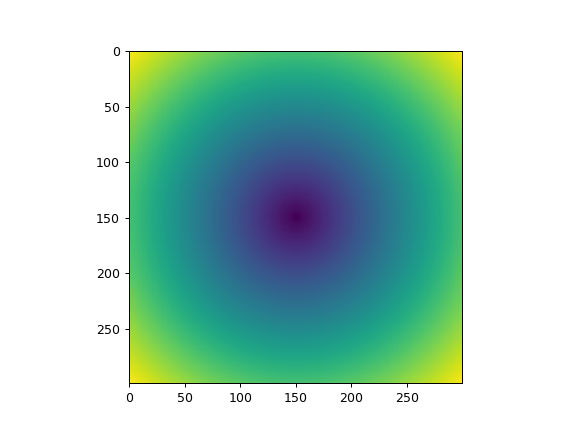

In [29]:
plt.figure()
plt.imshow(cell_distance_within_max_range)

In [53]:
NE_grid.shape

(2, 476, 581)

In [16]:
cell_x, cell_y = np.meshgrid(np.array(range(grid.shape[0])), np.array(range(grid.shape[1])))
cell_theta = np.arctan2(cell_y, cell_x)
cell_ranges = np.sqrt(cell_y ** 2 + cell_x ** 2)

In [45]:
cells.shape

(2, 581, 476)

In [36]:
points = np.vstack([data.iloc[0]['corrected_xs'], data.iloc[0]['corrected_ys']]) - current_location
ranges = np.sqrt(data.iloc[0]['corrected_xs'] ** 2 + data.iloc[0]['corrected_ys'] ** 2)
rays = points / ranges
cells = np.stack([cell_x, cell_y])
normalizd_cells = cells / cell_ranges
closest_ray_index = np.argmin(np.arccos((np.einsum('kij, kl -> ijl', normalizd_cells, normalized_points))), axis=2)
closest_range = ranges[closest_ray_index]
# next(data.iterrows())[1]['velodyne_points']
# data[0]

C:\Users\USER\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [38]:
closest_range.shape

(581, 476)

In [7]:
pd.set_option('display.max_rows', data.shape[0]+1)
print(data)

NameError: name 'data' is not defined

In [325]:
print(data.iloc[0]['lat'])
print(data.iloc[0]['lon'])

49.009947690751
8.4234877923254


In [17]:
initial_coords = [data.iloc[0]['lat'], data.iloc[0]['lon'], data.iloc[0]['alt']]
current_coords = [data.iloc[-1]['lat'], data.iloc[-1]['lon'], data.iloc[-1]['alt']]
diff = navpy.lla2ned(*(current_coords + initial_coords))
print(diff)

[112.72550667 -16.03461898   0.72956336]


In [330]:
c, s = np.cos(np.array(data['yaw'])), np.sin(np.array(data['yaw']))
local_NE_rotation = np.array(((c, -s), (s, c)))

In [15]:
print(diff)

[112.72550667 -16.03461898   0.72956336]


In [ ]:
for i in range(200):
    reoriented_points = local_NE_rotation[:,:,i] @ np.vstack([np.array((data['velo_xs'][i])), np.array((data['velo_ys'][i]))])
    fig = px.scatter(x=reoriented_points[0], y=reoriented_points[1])
    fig.update_layout(
        width=1400,
        height=2000
    )
    fig.show()

In [352]:
np.arctan(diff[1] / diff[0])

-0.14129692309124703

In [314]:
float(data.iloc[0]['lat'])

49.009947690751